# Ensayo de recrédito inhabilitado con incógnita de tasa

Este cuaderno tiene la simulación del escenario de habilitación de recrédito a clientes que aún no cumplen el 15% de pago a capital. La incógnita, a diferencia de la simulación anterior, es la tasa y no el monto.

In [1]:
import pandas as pd
import sys
from datetime import datetime
from dateutil.relativedelta import relativedelta
sys.path.append(r"C:\Users\mariajose_chinchilla\Documents\GitHub\proyectos_varios\codigos")
from utils import ingresos_financieros, ingreso_fin_entre_fechas, meses_entre_fechas

In [2]:
cartera = pd.read_csv(r"C:\Users\mariajose_chinchilla\Desktop\Octubre\db\Cartera_octubre.csv", sep=";")
#cartera = cartera[cartera["SALDO"] > 0]

C:\Users\mariajose_chinchilla\AppData\Local\Temp\ipykernel_59244\2943994546.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  cartera = pd.read_csv(r"C:\Users\mariajose_chinchilla\Desktop\Octubre\db\Cartera_octubre.csv", sep=";")


In [3]:
cartera.columns

Index(['FEC_SALDO', 'CODIGO_CLIENTE', 'DPI', 'NO_CREDITO', 'FECHA_APERTURA',
       'FECHA_CANCELACION', 'FECHA_VENCIMIENTO', 'COD_PATRONO', 'PATRONO',
       'COD_SEGMENTO', 'RCI', 'SEGMENTO', 'PLAZO', 'SALDO',
       'MONTO_DESEMBOLSADO', 'DESEMBOLSO_NETO', 'TASA', 'FACTOR_TASA',
       'ESTADO_CREDITO', 'TIPO_PAGO', 'CANTIDAD_DIAS_ATRASO',
       'CATEGORIA_INTERNA', 'CREDITO_CUMPLE_15', 'DEUDA_INTERNA'],
      dtype='object')

In [4]:
cartera.rename(columns={"MONTO_DESEMBOLSADO": "MONTO_DESEMBOLSADO",
                        "DESEMBOLSO_NETO": "DESEMBOLSO_NETO"}, inplace=True)

In [5]:
no_mes_simulacion = 12
nombre_mes = "DICIEMBRE"

In [25]:
# tratamiento de datos
cartera["FECHA_APERTURA"] = pd.to_datetime(cartera["FECHA_APERTURA"])
#cartera["MESES TRANSCURRIDOS"] = cartera.apply(lambda x: 12 * relativedelta(datetime.today(), x["FECHA_APERTURA"]).years + relativedelta(datetime.today(), x["FECHA_APERTURA"]).months, axis=1)
cartera["MESES TRANSCURRIDOS"] = cartera.apply(lambda x: 12 * relativedelta(datetime(2024, 12, 31), x["FECHA_APERTURA"]).months, axis=1)
cartera["MESES TRANSCURRIDOS"] = cartera["MESES TRANSCURRIDOS"].astype("int64")

In [7]:
def porcentaje_comision_desembolso(x):
    porcentaje = 0
    if x < 125000:
        porcentaje = 0.05
    elif x >= 125000:
        porcentaje = 0.02
    return porcentaje

cartera["PORCENTAJE COMISION DESEMBOLSO"] = cartera.apply(lambda x: porcentaje_comision_desembolso(x["DESEMBOLSO_NETO"]), axis=1)
cartera["COMISION PENDIENTE"] = (cartera["PORCENTAJE COMISION DESEMBOLSO"] * cartera["DESEMBOLSO_NETO"]) / cartera["PLAZO"] * (cartera["PLAZO"] - cartera["MESES TRANSCURRIDOS"])

In [8]:
def paga_reservas(x):
    if x < 0.15:
        return 1
    elif x >= 0.15:
        return 0
    
def tpp(factor_tasa, montos):
    return sum(factor_tasa) / sum(montos)
    
cartera["PORCENTAJE SALDO"] = 1- cartera["SALDO"] / cartera["MONTO_DESEMBOLSADO"]
cartera["FACTOR TASA"] = cartera["TASA"] * cartera["MONTO_DESEMBOLSADO"]
cartera_agrupado = cartera.groupby(by="CODIGO_CLIENTE").agg(PORCENTAJE_MINIMO=("PORCENTAJE SALDO", "min"),
                                                            CREDITOS_A_CANCELAR=("NO_CREDITO", list)).reset_index()
cartera_agrupado.columns = ["CODIGO_CLIENTE", "PORCENTAJE MINIMO", "CREDITOS A CANCELAR"]
cartera_agrupado["PAGA RESERVAS"] = cartera_agrupado.apply(lambda x: paga_reservas(x["PORCENTAJE MINIMO"]), axis=1)
cartera = pd.merge(cartera, cartera_agrupado, how="left", on="CODIGO_CLIENTE")

cartera_temp = cartera.groupby(by="CODIGO_CLIENTE").apply(lambda x: tpp(x["FACTOR TASA"], x["MONTO_DESEMBOLSADO"])).reset_index()
cartera_temp.columns = ["CODIGO_CLIENTE", "TPP CLIENTE"]
cartera = pd.merge(cartera, cartera_temp, how="left", on="CODIGO_CLIENTE")

In [9]:
cartera["INGRESOS A CANCELAR"] = cartera.apply(lambda x: ingreso_fin_entre_fechas(x["MONTO_DESEMBOLSADO"], x["TASA"]/1200, x["PLAZO"], x["MESES TRANSCURRIDOS"], x["MESES TRANSCURRIDOS"] + 12 +1 - no_mes_simulacion ), axis=1)
alpha = (0.08+0.0025) / (1 - 0.146)
cartera["PASIVOS A CANCELAR"] = cartera.apply(lambda x: ingreso_fin_entre_fechas(x["MONTO_DESEMBOLSADO"], alpha/12, x["PLAZO"], x["MESES TRANSCURRIDOS"] + 12 + 1 - no_mes_simulacion, x["MESES TRANSCURRIDOS"]), axis=1)
cartera_temp = cartera.groupby(by="CODIGO_CLIENTE").agg(PASIVOS_TOTALES_A_CANCELAR_CLIENTE=("PASIVOS A CANCELAR", "sum"),
                                                        INGRESOS_TOTALES_A_CANCELAR=("INGRESOS A CANCELAR", "sum"),
                                                        COMISIONES_A_TRAERSE=("COMISION PENDIENTE", "sum"),
                                                        ).reset_index()
cartera_temp.columns = ["CODIGO_CLIENTE", "PASIVOS TOTALES A CANCELAR CLIENTE", "INGRESOS TOTALES A CANCELAR", "COMISIONES A TRAERSE"]
cartera = pd.merge(cartera, cartera_temp, how="left", on="CODIGO_CLIENTE")

In [10]:
def calcular_tasa_oferta(margen_cancelado, monto_bruto, pasiva, mes):
    #tasa = 1.05 * margen_cancelado / monto_bruto + pasiva + (0.05)*(0.45)*(12 / (12 - mes))
    tasa = margen_cancelado / monto_bruto + pasiva + (0.05)*(0.45) / monto_bruto + 0.105
    if tasa > 0.25 or tasa < 0.14:
        return tasa
    elif tasa <= 0.25 and tasa >= 0.14:
        return tasa

cartera["MARGEN A CANCELAR"] = cartera["INGRESOS A CANCELAR"] - cartera["PASIVOS A CANCELAR"]
cartera["MONTO BRUTO OFERTA"] = cartera["DEUDA_INTERNA"] + cartera["DESEMBOLSO_NETO"].mean()

cartera["TASA OFERTA"] = cartera.apply(lambda x: calcular_tasa_oferta(x["MARGEN A CANCELAR"], x["MONTO BRUTO OFERTA"],
                                                                      alpha, no_mes_simulacion), axis=1)
cartera["PLAZO OFERTA"] = cartera["PLAZO"]

## Ver impacto de la iniciativa

In [11]:
resultados = cartera[cartera["PAGA RESERVAS"] == 1]
# resultados = resultados[resultados["TASA OFERTA"] != -1]
resultados = resultados.drop_duplicates(subset="CODIGO_CLIENTE")
resultados[f"INGRESOS FINANCIERSO A {nombre_mes}"] = resultados.apply(lambda x: ingresos_financieros(x["MONTO BRUTO OFERTA"], x["TASA OFERTA"]/12, x["PLAZO OFERTA"], 12 - no_mes_simulacion + 1), axis=1)

resultados["NUEVOS PASIVOS EN EL AÑO"] = resultados.apply(lambda x: ingresos_financieros(x["MONTO BRUTO OFERTA"], alpha/12, x["PLAZO OFERTA"], 12 - no_mes_simulacion + 1), axis=1)
resultados["PASIVOS NUEVOS TOTALES"] = resultados.apply(lambda x: ingresos_financieros(x["MONTO BRUTO OFERTA"], alpha/12, x["PLAZO OFERTA"], x["PLAZO OFERTA"]), axis=1)

#resultados = resultados[(resultados["PAGA RESERVAS"] == 1) & (resultados["MONTO BRUTO OFERTA"] < 300000)
                    #& (resultados["MONTO BRUTO OFERTA"] > 0)]

resultados["RESERVAS POR REESTRUCTURA"] = 0.05 * 0.45 * resultados["PAGA RESERVAS"] * resultados["MONTO BRUTO OFERTA"]
resultados["MARGEN NUEVO"] = resultados[f"INGRESOS FINANCIERSO A {nombre_mes}"] - resultados["RESERVAS POR REESTRUCTURA"] - resultados["NUEVOS PASIVOS EN EL AÑO"]
resultados["DIFERENCIA MARGEN"] = resultados["MARGEN NUEVO"] - resultados["MARGEN A CANCELAR"]
resultados["FACTOR TASA OFERTA"] = resultados["TASA OFERTA"] * resultados["MONTO BRUTO OFERTA"]

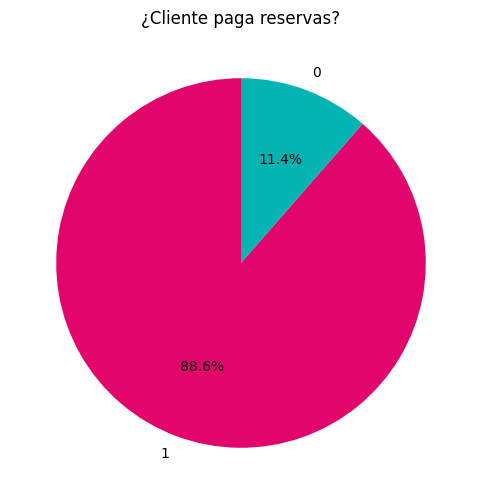

In [12]:
import matplotlib.pyplot as plt
grafica = cartera["PAGA RESERVAS"].value_counts()
colors = ["#e2056b", "#04b4b3"]
plt.figure(figsize=(10,6))
plt.pie(grafica, labels=grafica.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('¿Cliente paga reservas?')
plt.show()

In [13]:
a = resultados[(resultados["RCI"].isna() | resultados["RCI"] <= 60) & (resultados["MONTO BRUTO OFERTA"] <= 300000)]
# a = resultados[(resultados["DIFERENCIA MARGEN"] < 0)]
# a = resultados.copy()
vars = [f"INGRESOS FINANCIERSO A {nombre_mes}",
"MONTO BRUTO OFERTA",
"INGRESOS TOTALES A CANCELAR",
"NUEVOS PASIVOS EN EL AÑO",
"PASIVOS A CANCELAR",
"RESERVAS POR REESTRUCTURA",
"COMISIONES A TRAERSE",
"MARGEN A CANCELAR",
"MARGEN NUEVO",
"DIFERENCIA MARGEN"]
for var in vars:
    print(f"{var} es {int(a[var].sum() / 10**6)} M")

INGRESOS FINANCIERSO A DICIEMBRE es 300 M
MONTO BRUTO OFERTA es 17423 M
INGRESOS TOTALES A CANCELAR es 257 M
NUEVOS PASIVOS EN EL AÑO es 140 M
PASIVOS A CANCELAR es 105 M
RESERVAS POR REESTRUCTURA es 392 M
COMISIONES A TRAERSE es 16 M
MARGEN A CANCELAR es 96 M
MARGEN NUEVO es -231 M
DIFERENCIA MARGEN es -328 M


In [14]:
resultados[["DEUDA_INTERNA", "MONTO BRUTO OFERTA"]]

,DEUDA_INTERNA,MONTO BRUTO OFERTA
0,496897.77,499333.789757
2,175000.00,177436.019757
3,135167.83,137603.849757
4,82430.98,84866.999757
6,105000.00,107436.019757
...,...,...
203498,91341.40,93777.419757
203500,179565.29,182001.309757
203502,6323.30,8759.319757
203503,209509.81,211945.829757


In [15]:
resultados["COMISION PENDIENTE"].sum() / 10**6

14.104359443194342

In [16]:
# def pasa_cotizador(monto_oferta, tasa_oferta, deuda_interna, tpp_vieja):
#     pasivos = (0.08 + 0.0025)/(1 - 0.146)
#     margen_nuevo = monto_oferta * tasa_oferta - monto_oferta * pasivos
#     margen_cancelado = deuda_interna * tpp_vieja / 100 - deuda_interna * pasivos
#     reservas = monto_oferta * 0.05 * 0.45
#     if margen_nuevo - margen_cancelado - reservas > 0:
#         return 1
#     else:
#         return 0
    
# def tasa_erick(deuda_interna, tpp_vieja, desembolso_bruto, mes):
#     pasivos = (0.08 + 0.0025)/(1 - 0.146)
#     mf_cancelado = deuda_interna * tpp_vieja/100 - deuda_interna * pasivos
#     reserva = (0.05 * 0.45) * 12
#     return max(1.05 * mf_cancelado / desembolso_bruto + pasivos + reserva / (12 - mes), tpp_vieja/100)

In [17]:
# resultados["MONTO BRUTO OFERTA"] = resultados["DEUDA_INTERNA"] + resultados["DESEMBOLSO_NETO"].mean() 
# resultados["TASA ERICK"] = resultados.apply(lambda x: tasa_erick(x["DEUDA_INTERNA"], x["TPP CLIENTE"], x["MONTO BRUTO OFERTA"], no_mes_simulacion), axis=1)
# resultados["PASA COTIZADOR"] = resultados.apply(lambda x: pasa_cotizador(x["MONTO BRUTO OFERTA"], x["TASA ERICK"], x["DEUDA_INTERNA"], x["TPP CLIENTE"]), axis=1)

In [18]:
# base_comerciales = resultados[(resultados["PASA COTIZADOR"] == 1) & (resultados["TASA ERICK"] < 0.25) & (resultados["TASA ERICK"] > 0.14)]
# base_comerciales["MES"] = nombre_mes
# base_comerciales.drop_duplicates(subset="CODIGO_CLIENTE", inplace=True)
# base_comerciales[["CODIGO_CLIENTE", "DPI", "MONTO BRUTO OFERTA", "MES"]].to_excel(f"../db/{nombre_mes}_base_comerciales.xlsx")

In [19]:
# agosto = pd.read_excel("../db/Agosto_base_comerciales.xlsx")
# septiembre = pd.read_excel("../db/SEPTIEMBRE_base_comerciales.xlsx")
# base_total = pd.concat([agosto, septiembre])
# base_total.to_excel("../db/BASE FINAL RECREDITO.xlsx")

In [20]:
# compra_saldo = pd.read_excel("../db/compraSaldo.xlsx")
# liquidez = pd.read_excel("../db/liquidez.xlsx")

In [21]:
# base_total = pd.merge(base_total, total, left_on="DPI", right_on="DxDpi", how="inner")

In [22]:
# import numpy as np
# base_total["PROBABILIDAD DE COMPRA"] = np.where(base_total["MONTO BRUTO OFERTA"] <= base_total["DfMontoMaximoOfertado"], 1, 0)

In [23]:
# base_total = base_total[["CODIGO_CLIENTE", "DPI", "MONTO BRUTO OFERTA", "MES", "PROBABILIDAD DE COMPRA"]]

In [24]:
# agosto = base_total[base_total["MES"] == "AGOSTO"]
# sept = base_total[base_total["MES"] == "SEPTIEMBRE"]

# agosto.to_excel("../db/AGOSTO_BASE.xlsx")
# sept.to_excel("../db/SEPTIEMBRE_BASE.xlsx")